### Read the station data from GHCN archive ###

Data obtained from http://www.ncdc.noaa.gov/cdo-web/

In [319]:
from __future__ import print_function, division
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import math
#import seaborn as sns
import os
import glob
%matplotlib inline

In [ ]:
def get_date(date_number):
    """
    Turn the int64 value from the DATE of GHCN into a pd.datetime
    """
    dstring = str(date_number)
    return pd.datetime(int(dstring[0:4]),int(dstring[4:6]),int(dstring[6:8]))

def get_df(fnm, var, no_missing = True):
    """
    Create a dataframe for a single station, with a time index, for a single
    variable of data given as a key word (e.g. PRECIP, TMAX, TMIN).
    Requires file path and name (fnm).
    no_missing is a Bool that optionally masks out values < -99 from the df.
    """
    df = pd.read_csv(fnm)
    dt_indx = [get_date(date) for date in df.DATE]
    data_vals = df[var].values
    if var is 'PRCP':
        data_vals = data_vals / 10.  # This is to convert precip data to mm
    if no_missing:
        tmp_df = pd.DataFrame(data=data_vals,
                              index=dt_indx,columns=[df.STATION[0][6:]])
        mask = tmp_df > -99.  # A catchall value for missing data in GHCN
        return tmp_df[mask]
    else:
        return pd.DataFrame(data=data_vals,
                            index=dt_indx,columns=[df.STATION[0][6:]])

def get_combined_df(fpth, var):
    """
    From a given file path, and variable, extract data from all .csv files, and
    place in a single dataframe object.
    """
    flist = glob.glob(fpth)
    df_dic = {}
    for f in flist:
        df_dic[f[5:]] = get_df(fnm = f, var = var, no_missing=True)
    return pd.concat([df_dic[key] for key in df_dic.keys()],axis=1)

Call the Get_combined() function to create dataframes out of all data in a folder.

In [ ]:
%%time
df_tmax = get_combined_df(fpth="Data/*.csv",var="TMAX")
df_tmin = get_combined_df(fpth="Data/*.csv",var="TMIN")
df_prcp = get_combined_df(fpth="Data/*.csv",var="PRCP")

### Start of analysis ###

Plot time series of precipitation for all stations, and also accumulate the data and plot the average rainfall.

In [ ]:
# Example of masking and accessing data from stations...
station = df_prcp.keys()[4]
plt.plot(df_prcp[station].index,df_prcp[station],'.',alpha=0.5)
plt.title("Station {0:s}".format(station))

In [ ]:
df_prcp.KE000063740['2015']

In [ ]:
df_prcp.KE000063740[df_prcp.KE000063740 > 100]

## Time series plots

In [ ]:
def daily_mean(date, df):
    """
    Return the mean value for all stations on a specified day,
    ignoring NAN values.
    """
    tmp = np.array([df_prcp[key][day] for key in df_prcp.keys()])
    valid = tmp > -1
    tmp = tmp[valid]
    mean = np.mean(tmp)
    std = np.std(tmp)
    count = len(tmp)
    sem = std/np.sqrt(count -1)
    return mean, std, count, sem

In [ ]:
daily_mean(date=day,df=df_prcp)

In [ ]:
means = []
stds = []
sems = []
for day in df_prcp.index:#[10000:10005]
    tmp = np.array([df_prcp[key][day] for key in df_prcp.keys()])
    valid = tmp > -1
    tmp = tmp[valid]
    mean = np.mean(tmp)
    std = np.std(tmp)
    count = len(tmp)
    sem = std/np.sqrt(count -1)
    #print(day.date())
    #print(daily_mean(date=day, df=df_prcp))
    means.append(mean)
    stds.append(std)
    sems.append(sem)

In [ ]:
mean

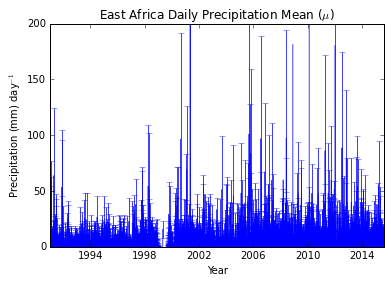

In [383]:
plt.errorbar(df_prcp.index,means,yerr=sems,xerr=None,alpha=0.75)
plt.xlim(xmin='1991-01-01',xmax='2015-08-31')
plt.ylim((0.0,200))
plt.title("East Africa Daily Precipitation Mean ($\mu$) ")
plt.ylabel("Precipitation (mm) day$^{-1}$")
plt.xlabel("Year")

In [ ]:
#plt.plot(df_prcp.index, means, '.r', df_prcp.index, sems, '.g')

In [ ]:
np.shape(means)

Calculate the DOY mean (μ) and Standard Error of the Mean (SEM) uncertainity. 
Mean uncertainty is given in SEM, where: $$ SEM = \frac {\sigma} {\sqrt{n-1}}$$

In [ ]:
doy_mean=[]
doy_sem =[]
doy_csum=[]
for doy in range(366):
    index = df_prcp.index.dayofyear == doy+1 
    cum_sum= df_prcp.index.dayofyear.cumsum() == doy+1
    #print (cum_sum)
    doy_mean.append(np.nanmean(df_prcp[index]))
    doy_sem.append(np.nanstd(df_prcp[index])/np.sqrt(len(df_prcp[index])-1))
    doy_csum.append(np.nanmean(cum_sum))
  

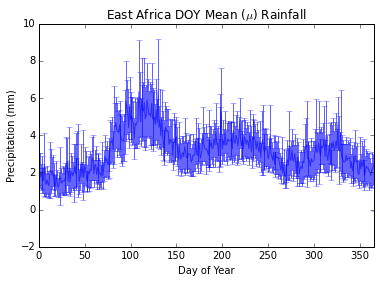

In [345]:
plt.errorbar(range(366),doy_mean,xerr=None, yerr=doy_sem, alpha=0.6)
plt.xlim(0,max(range(366)))
plt.title("East Africa DOY Mean ($\mu$) Rainfall")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Day of Year")

Correlation Matrix

In [ ]:
corr_matrix = df_prcp
corr_matrix.corr(method='pearson', min_periods=1)

In [ ]:
df_prcp.keys()

Accumulated Mean and SEM values

In [ ]:
def get_month_mean(date, df):
    tmp = np.array([df_prcp[key][month] for key in df_prcp.keys()])
    cur_month = date.month
    cur_year = date.year
    
Acc_mean =[]
Acc_sem = []
for month in df_prcp.index:
    # index = df_prcp.index.month == month+1 
    Acc_mean.append(np.nanmean(index))
    Acc_sem.append(np.nanstd(index)/np.sqrt(len(index) -1))

In [382]:
###Calculate monthly anomalies
##  Anomalies = Observation - Climatology

anomalies = []
for n,day in enumerate(df_prcp.index.values):
    #print("Index: {0} Date: {1} Value: {0:3.3f}".format(n,df_prcp.index[n].date(),day[0]))
    doyi = df_prcp.index[n].dayofyear -1 # Create an index to call doy_mean
    #print(n, doy_mean[doyi])
    anomalies.append(doy - doy_mean[doyi])

In [ ]:
plt.plot(df_prcp.KE000063612.index,anomalies)

In [ ]:
#print(df.DATE[0])
#print(type(df.DATE[0]))
#df.DATE[0]